In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, random, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm # progress bar
from sklearn.preprocessing import LabelBinarizer
from keras.regularizers import l2

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

# Utility Functions

In [2]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['binary_accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_binary_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [3]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

# Uploading the images

In [ ]:
# from google.colab import files
# import zipfile
# import os

# # Step 1: upload the .zip file
# uploaded = files.upload()

# # assuming there is only one file
# zip_name = list(uploaded.keys())[0]

# # Step 2: Unzip the .zip file
# with zipfile.ZipFile(zip_name,"r") as zip_ref:
#     zip_ref.extractall()

# print("Folder uploaded successfully")

In [4]:
datasets = ['D:\Microsoft Hackthon\Data\Data2\Data2']

class_names = ["Windmill","OilRig"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'Windmill': 0, 'OilRig': 1}

In [5]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            if folder in class_name_labels:
                label = class_name_labels[folder]

                for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                    # Skip - Colab skip .ipy_checkpoints
                    if file.startswith('.'):
                        continue

                    img_path = os.path.join(dataset,folder,file)

                    # Ensure the path is a file (not a directory)
                    if os.path.isfile(img_path):
                        img = cv2.imread(img_path)
                        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (36, 36))
                        images.append(img)
                        labels.append(label)

    images = np.array(images, dtype=np.float32)/255.0
    labels = np.array(labels, dtype=np.float32)

    return (images, labels)

In [6]:
(images, labels) = load_data()
images.shape, labels.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2009/2009 [00:10<00:00, 185.26it/s]


((7933, 36, 36, 3), (7933,))

# Note that the folder contains 2 types of Image:
 - 1. Image with windmill
 - 2. Image with OilRigs

In [7]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

Count
Class-Label       
Windmill      5926
OilRig        2007

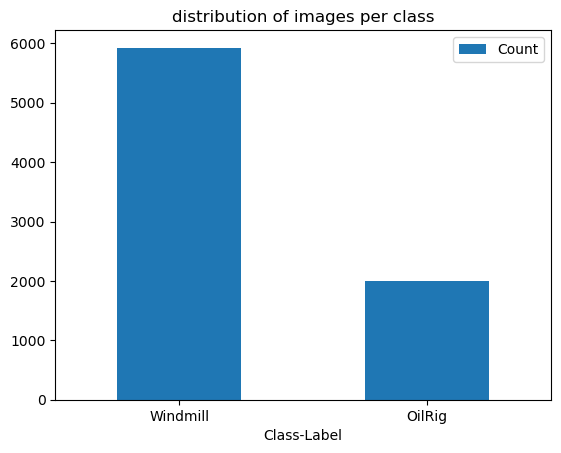

In [8]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

###### As it can be seen that the data is skewed towards the windmill class with 74.23% of images belonging to that very specific class.

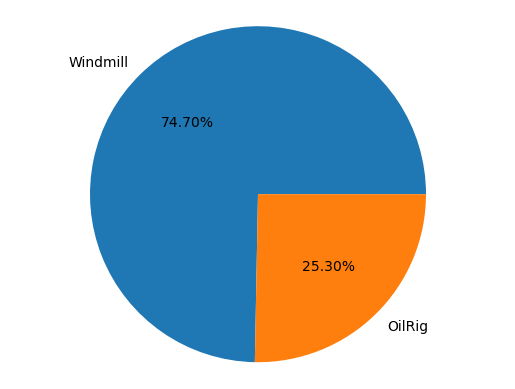

In [9]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

# Augument more image of oil rigs to address unequal sampling.

The current ratio of classes is 1:3 means every 1 oilrig image is for 3 windmill images. We need to produce addition 2 images for every Oil rigs. Because they are very similar. The augumentation will have very small parameter for altertation

In [10]:
AUGMENTATION = True

In [11]:
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass

Parameter for augumentation

In [12]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.05)),
    iaa.Affine(
        rotate=(-10, 10),  # Slightly rotates images
    )
], random_order=True)  # Apply the augmentations in random order

In [13]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

7933it [00:02, 3407.27it/s] 


In [14]:
images.shape, labels.shape

((11947, 36, 36, 3), (11947,))

# New data distrubtion after Data augumentation

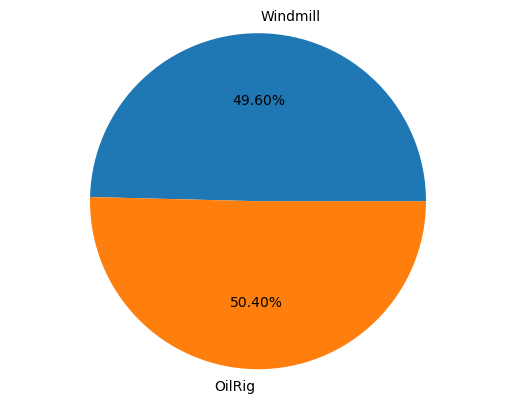

In [15]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

## close to 50/50. We are happy.

# Convert

In [16]:
labels = (labels > 0.5).astype(int)


# Train, Validation, Testing data set split

In [17]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

# Classic split ratio : 70% - 20% - 10% split

In [18]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

print(train_images.shape, val_images.shape, test_images.shape)

print(train_labels.shape, val_labels.shape, test_labels.shape)

(8362, 36, 36, 3) (2389, 36, 36, 3) (1194, 36, 36, 3)
(8362,) (2389,) (1194,)


In [19]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

In [20]:
def conv_block(X,k,filters,stage,block,s=2,dropout=0.5,regularizer=l2(0.01)):

    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    X = Dropout(dropout)(X)

    return X

## Overfitting:
Add a penalty for complexity to the loss function. Increase the regularization strength, reduce the model complexity, or get more data for training if possible.

In [23]:
def basic_model(input_shape,classes,dropout=0.5,regularizer=l2(0.01)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3,3))(X_input)

    X = Conv2D(8,(3,3),strides=(2,2),name='conv1',padding="same", kernel_regularizer=regularizer)(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,16,2,block='A',s=1,dropout=dropout,regularizer=regularizer)
    X = MaxPooling2D((2,2))(X)

    # Stage 3
    X = conv_block(X,5,16,3,block='A',s=2,dropout=dropout,regularizer=regularizer)
    X = MaxPooling2D((2,2))(X)

    # Stage 4
    X = conv_block(X,3,32,4,block='A',s=1,dropout=dropout,regularizer=regularizer)
    X = MaxPooling2D((2,2))(X)

    # Output Layer
    X = Flatten()(X)
    X = Dense(32, kernel_regularizer=regularizer)(X)
    X = Dropout(dropout)(X)

    X = Dense(64, kernel_regularizer=regularizer)(X)
    X = Activation("relu")(X)

    X = Dense(1,activation="sigmoid",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='WindOil_36')

    return model

In [24]:
model = basic_model(input_shape=(36,36,3),classes=2)

# Model structure

In [44]:
!pip install pydot graphviz

     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [46]:
plot_model(model, to_file='D:\Microsoft Hackthon\Images\basic_model36.png', show_shapes=True, show_layer_names=True)


model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "WindOil_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 42, 42, 3)         0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 21, 21, 8)         224       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 21, 21, 8)         32        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 21,

## Complie

come back check learning rate

In [27]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])


In [33]:
logs = TensorBoard('D:\Microsoft Hackthon\Code/my_logs3636')

# Training

1. Try 10 Epoch 32 batch size

- Try 100 eporch

In [34]:
epochs = 100
batch_size = 32
steps_per_epoch = len(train_images)// batch_size

print(steps_per_epoch)

261


In [35]:
print(f'Training images length: {len(train_images)}')
print(f'Validation images length: {len(val_images)}')
print(f'Steps per epoch: {len(train_images)//batch_size}')
print(f'Validation steps: {len(val_images)//batch_size}')

Training images length: 8362
Validation images length: 2389
Steps per epoch: 261
Validation steps: 74


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [36]:
history = model.fit(train_images,train_labels,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   callbacks=[logs, early_stopping, lr_schedule]
                   )

Epoch 1/100
262/262 [==============================] - 6s 16ms/step - loss: 1.4656 - binary_accuracy: 0.7588 - val_loss: 1.3766 - val_binary_accuracy: 0.5232
Epoch 2/100
262/262 [==============================] - 4s 15ms/step - loss: 0.7601 - binary_accuracy: 0.9385 - val_loss: 0.8943 - val_binary_accuracy: 0.7405
Epoch 3/100
262/262 [==============================] - 4s 16ms/step - loss: 0.4737 - binary_accuracy: 0.9559 - val_loss: 0.8596 - val_binary_accuracy: 0.5873
Epoch 4/100
262/262 [==============================] - 4s 17ms/step - loss: 0.3310 - binary_accuracy: 0.9598 - val_loss: 0.3774 - val_binary_accuracy: 0.9749
Epoch 5/100
262/262 [==============================] - 5s 18ms/step - loss: 0.2689 - binary_accuracy: 0.9605 - val_loss: 0.3844 - val_binary_accuracy: 0.9226
Epoch 6/100
262/262 [==============================] - 6s 21ms/step - loss: 0.2310 - binary_accuracy: 0.9616 - val_loss: 0.2747 - val_binary_accuracy: 0.9556
Epoch 7/100
262/262 [==============================]

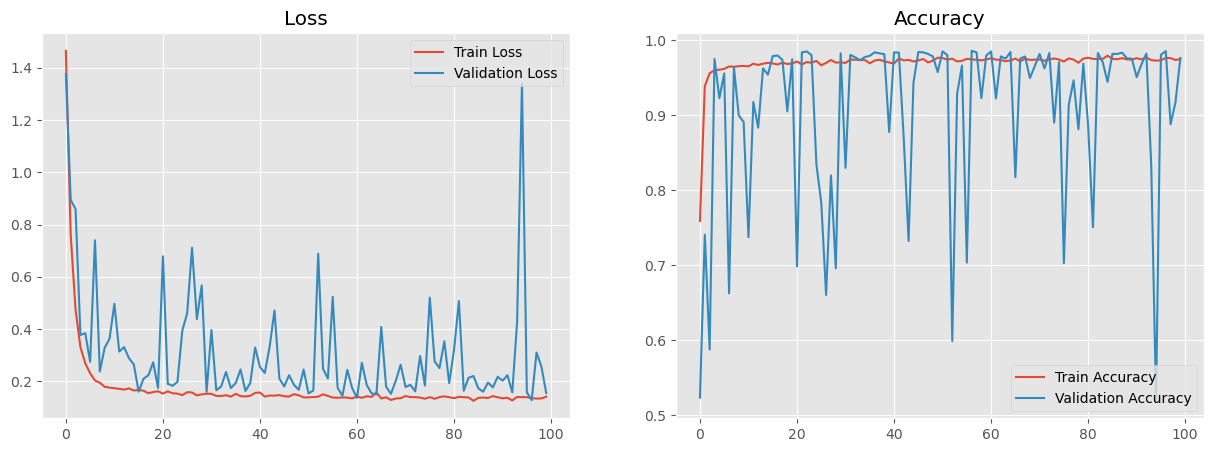

In [37]:
show_final_history(history)

75/75 [==============================] - 1s 5ms/step


<Figure size 640x480 with 0 Axes>

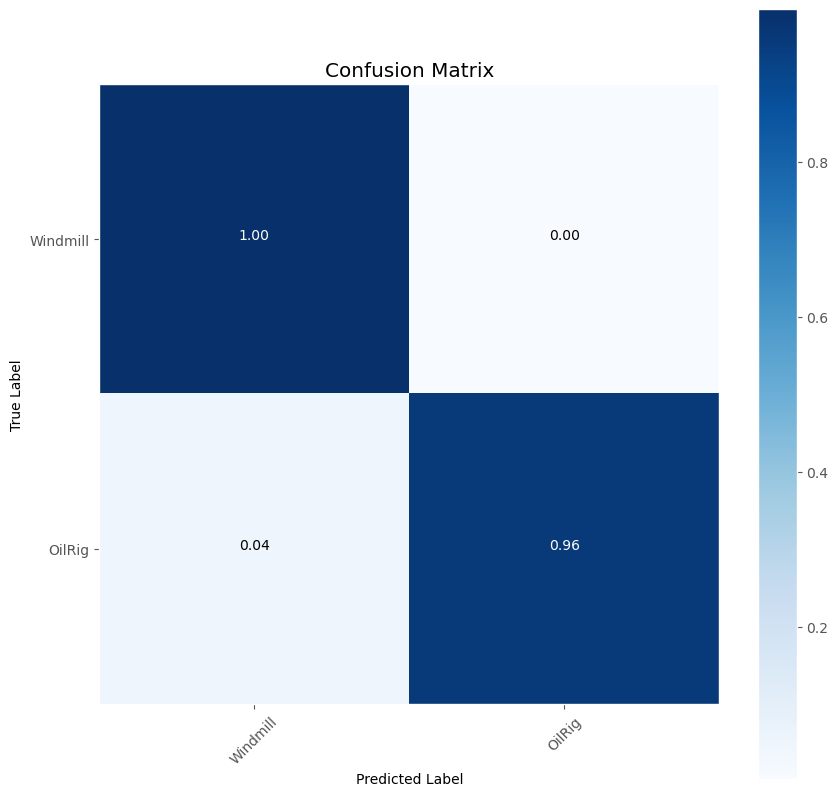

In [38]:
val_pred = model.predict(val_images)
val_pred = np.squeeze(val_pred)
val_pred = (val_pred > 0.5).astype(int)


val_actual = val_labels

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

38/38 [==============================] - 0s 5ms/step


<Figure size 640x480 with 0 Axes>

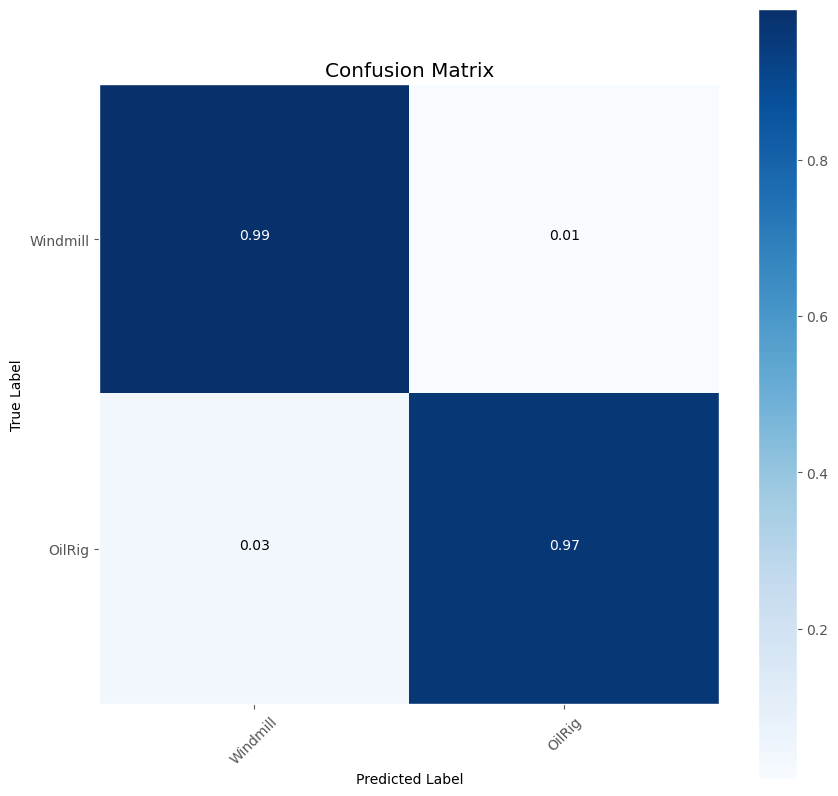

In [40]:
test_pred2 = model.predict(test_images)
test_pred2 = np.squeeze(test_pred2)
test_pred = (test_pred2 > 0.5).astype(int)
test_actual = test_labels
cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

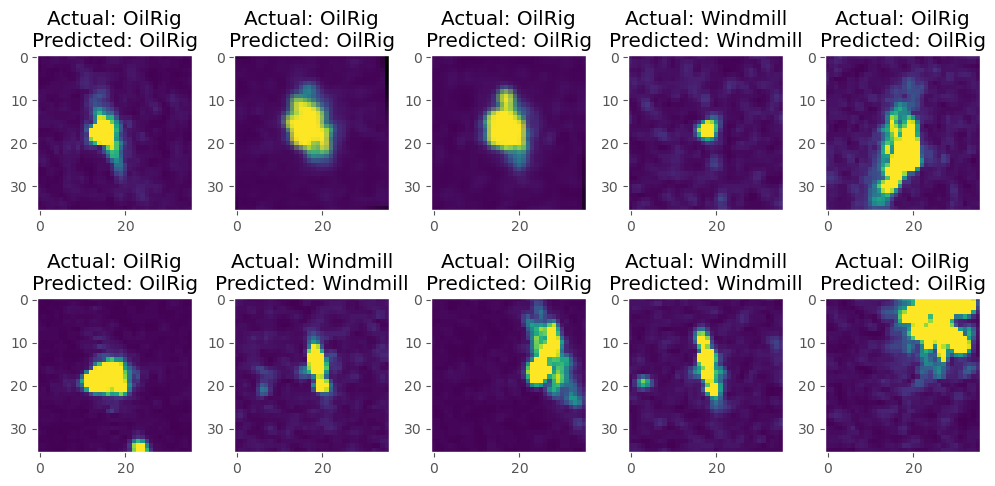

In [41]:
rnd_idx = random.sample(range(0, 400), 10)
class_labels = {i: class_name for (class_name, i) in class_name_labels.items()}

fig, ax = plt.subplots(2, 5, figsize=(10, 5))

for i, idx in enumerate(rnd_idx):
    row = i // 5
    col = i % 5

    ax[row, col].imshow(test_images[idx])
    ax[row, col].set_title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]], class_labels[test_pred[idx]]))
    ax[row, col].grid(None)

plt.tight_layout()
plt.show()

In [42]:
model.save("D:\Microsoft Hackthon\Model\WindLandOil_Model_Final_36.h5")

C:\Users\tong.ding\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
